In [1]:
from openmm.app import *
from openmm import *
from openmm.unit import *
from sys import stdout

from openmm.app import *
from openmm import *
from simtk.unit import *
from sys import stdout

import numpy as np
import matplotlib.pyplot as plt

import MDAnalysis as mda

C:\Users\wular\anaconda3\envs\inspire_test\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
stru_file = './data/h4_fragment/H4_FRAGMENT.pdb'

# 1.loading initial coordinates
pdb = PDBFile(stru_file) 

# 2.choosing a forcefield parameters. Recall -- this is the combination of potential functions and parameters.
ff = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')  
system = ff.createSystem(pdb.topology, nonbondedMethod=CutoffNonPeriodic)

# 3. Choose parameters of the experiment: temperature, pressure, box size, solvation, boundary conditions, etc
temperature = 300 * kelvin
frictionCoeff = 1. / picoseconds
time_step = 0.002 * picoseconds
total_steps = 20_000 * picoseconds / time_step

print(f'Total timesteps = {int(total_steps)}.')

# 4. Choose an algorithm (integrator)
integrator = LangevinIntegrator(temperature, frictionCoeff, time_step)

# 5. Run simulation, saving coordinates time to time:

# 5a. Create a simulation object
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)

# 5b. Minimize energy
simulation.minimizeEnergy()

# 5c. Save coordinates to dcd file and energies to a standard output console:
simulation.reporters.append(XTCReporter('data/h4_fragment.xtc', 1000))
simulation.reporters.append(StateDataReporter(
    stdout,
    50_000,
    step=True, 
    potentialEnergy=True,
    temperature=True,
    progress=True,
    totalSteps = total_steps
))
# write out temp, potential energy, time.
simulation.reporters.append(StateDataReporter('./data/h4_fragment.csv', 1000, time=True, 
                                              temperature=True, potentialEnergy=True)
                           )

# 5d. Run the simulation!
simulation.step(total_steps)

import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import rmsd

ref = mda.Universe('./data/h4_fragment/H4_FRAGMENT.pdb')
mobile = mda.Universe('./data/h4_fragment/H4_FRAGMENT.pdb', './data/h4_fragment.xtc')

alignment = align.AlignTraj(mobile, ref, filename='./data/H4_FITTED.xtc')
alignment.run(verbose=True)


Total timesteps = 10000000.
#"Progress (%)","Step","Potential Energy (kJ/mole)","Temperature (K)"
0.5%,50000,2051.5585327148438,298.1805893597096
1.0%,100000,2276.2200927734375,320.3446460244685
1.5%,150000,2222.0379638671875,291.82870316233766
2.0%,200000,2121.7998657226562,317.0701088817697
2.5%,250000,2174.841552734375,322.7749254666033
3.0%,300000,2140.112060546875,295.787310585139
3.5%,350000,2330.3172607421875,311.30584893923714
4.0%,400000,2135.388671875,312.66280534118306
4.5%,450000,2269.3472900390625,309.2213641120712
5.0%,500000,2169.6209716796875,297.2471333970119
5.5%,550000,2267.3839111328125,291.78337450060155
6.0%,600000,2300.2516174316406,301.9167883732291
6.5%,650000,2277.3714599609375,308.34901156951804
7.0%,700000,2197.1677856445312,296.38919631029705
7.5%,750000,2282.0611572265625,302.5178097652679
8.0%,800000,2218.2147827148438,312.4388498247477
8.5%,850000,2165.652557373047,300.20847103959574
9.0%,900000,2172.5906372070312,298.8109029272993
9.5%,950000,2222.07055

C:\Users\wular\anaconda3\envs\inspire_test\Lib\site-packages\MDAnalysis\coordinates\XDR.py:253: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1297.34it/s]


# We can again use AlphaFold to generate a prediction as to the final structure of our protein
- Using the following sequence for our protein: `EAQPTKSLDDNKSLKDDQKKL`, use the [AlphaFold notebook](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb#scrollTo=kOblAo-xetgx) to generate a prediction of the final structure.

### Example 6.2. Analysis of MD trajectory.
---
**End-to-end distance**

Let's perform analysis related to the structure of the protein. Let's look at the protein end-to-end distance over time.



100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 6060.24it/s]


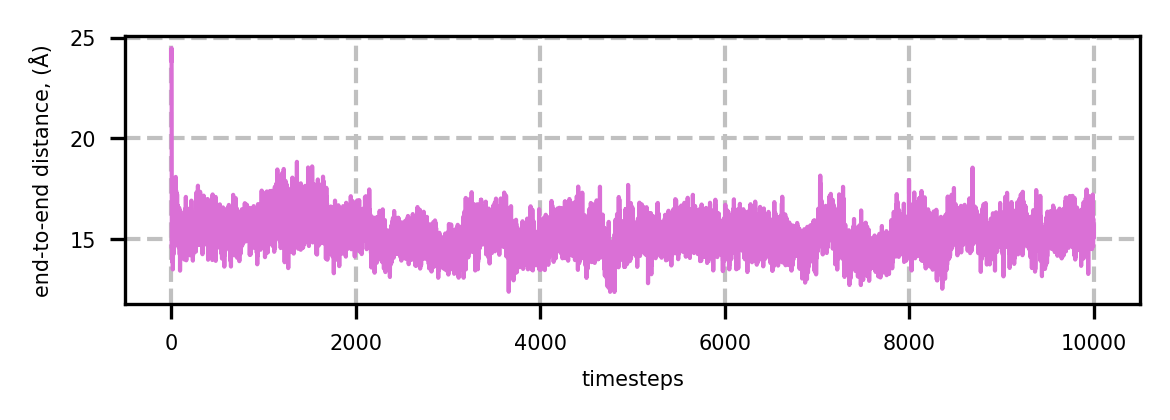

In [3]:
from tqdm import tqdm 

### analysis of end-to-end distance

# we must first load the trajectory as an MDAnalysis universe object
universe = mda.Universe('./data/h4_fragment/H4_FRAGMENT.pdb', './data/h4_fragment.xtc') # requires a .pdb (topology) and a .xtc (trajectory)

# ## choose terminal atoms 
N_terminus = universe.select_atoms('resid 105 and name C')
C_terminus = universe.select_atoms('resid 126 and name N')

## go through the whole trajectory and compute distance between them for every frame
dist = []
for frame in tqdm(universe.trajectory):
    dist.append(np.linalg.norm(N_terminus.positions - C_terminus.positions))
dist = np.asarray(dist) 

plt.figure(figsize=(4, 1.5), dpi=300)
plt.grid(axis='both', ls='--', lw=1, color='silver', zorder=1)
plt.plot(dist, color='orchid', lw=1, zorder=101)
plt.xlabel('timesteps', fontsize=5)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.ylabel(r'end-to-end distance, (Å)', fontsize=5)
plt.tight_layout()
plt.show()

<hr>

In [ ]:
# Similar to Example 6.1

In [ ]:
pdb_file = 'H4_FRAGMENT'

def _do_simulation(temperature: float, pdb_file: str):

    # 1.loading initial coordinates
    pdb = PDBFile('./data/h4_fragment/' + pdb_file +'.pdb') 

    # 2.choosing a forcefield parameters. Recall -- this is the combination of potential functions and parameters.
    ff = ForceField('amber14-all.xml')  
    system = ff.createSystem(pdb.topology, nonbondedMethod=CutoffNonPeriodic)

    # 3. Choose parameters of the experiment: temperature, pressure, box size, solvation, boundary conditions, etc
    temperature = temperature * kelvin
    frictionCoeff = 1. / picoseconds
    time_step = 0.002 * picoseconds
    total_steps = 10_000 * picoseconds / time_step
    
    print(f'Total timesteps = {int(total_steps)}.')
    
    # 4. Choose an algorithm (integrator)
    integrator = LangevinIntegrator(temperature, frictionCoeff, time_step)
    
    # 5. Run simulation, saving coordinates time to time:
    
    # 5a. Create a simulation object
    simulation = Simulation(pdb.topology, system, integrator)
    simulation.context.setPositions(pdb.positions)
    
    # 5b. Minimize energy (ask: why do we do this?!)
    simulation.minimizeEnergy()
    
    # 5c. Save coordinates to dcd file and energies to a standard output console:
    simulation.reporters.append(XTCReporter(f'data/{pdb_file}_{temperature}_traj.xtc', 1000))
    simulation.reporters.append(StateDataReporter(
        stdout,
        50_000,
        step=True, 
        potentialEnergy=True,
        temperature=True,
        progress=True,
        totalSteps = total_steps
    ))
    # write out temp, potential energy, time.
    simulation.reporters.append(StateDataReporter(f'./data/{pdb_file}_{temperature}_output.csv', 1000, time=True, 
                                                  temperature=True, potentialEnergy=True)
                               )
    # 5d. Run the simulation!
    simulation.step(total_steps)
    
    import numpy as np
    import matplotlib.pyplot as plt
    
    output = np.loadtxt(f'data/{pdb_file}_{temperature}_output.csv', delimiter=',', usecols=[0,1,2], dtype=float)
    
    time          = output[:, 0]
    energy_V      = output[:, 1]
    temperature_T = output[:, 2]
    
    fig,axs = plt.subplots(1, 2, dpi=300, figsize=(10, 3))
    axs.flatten()

    for i in range(len(axs)):
        axs[i].grid(axis='both', color='silver', ls='--', lw=1, zorder=1)
    
    axs[0].plot(time, temperature_T, color='crimson', zorder=101)
    axs[0].set_xlabel('Time (ps)', fontsize=10)
    axs[0].set_ylabel('Temperature (K)', fontsize=10)
    
    axs[1].plot(time, energy_V, label='$V$', color='dodgerblue', zorder=101)
    axs[1].set_ylabel('Potential energy (kJ/mol)', fontsize=10)
    axs[1].set_xlabel('Time (ps)', fontsize=10)
    
    plt.tight_layout()
    plt.show()

    return None


# _do_simulation(200, pdb_file)
# _do_simulation(300, pdb_file)
_do_simulation(400, pdb_file)



In [ ]:
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import rmsd

ref = mda.Universe('./data/h4_fragment/H4_FRAGMENT.pdb')
mobile = mda.Universe('./data/h4_fragment/H4_FRAGMENT.pdb', './data/H4_FRAGMENT_400 K_traj.xtc')

alignment = align.AlignTraj(mobile, ref, filename='./data/ALIGNED_400K.xtc')
alignment.run(verbose=True)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

def _get_endtoend(universe): 
    from tqdm import tqdm 
    N_terminus = universe.select_atoms('resid 105 and name C')
    C_terminus = universe.select_atoms('resid 126 and name N')
    dist = []
    for frame in tqdm(universe.trajectory):
        dist.append(np.linalg.norm(N_terminus.positions - C_terminus.positions))
    dist = np.asarray(dist)
    return dist

stru_file = './data/h4_fragment/H4_FRAGMENT.pdb'

u200 = mda.Universe(stru_file, './data/H4_FRAGMENT_200 K_traj.xtc')
u300 = mda.Universe(stru_file, './data/H4_FRAGMENT_300 K_traj.xtc')
u400 = mda.Universe(stru_file, './data/H4_FRAGMENT_400 K_traj.xtc')

etoe200 = _get_endtoend(u200)
etoe300 = _get_endtoend(u300)
etoe400 = _get_endtoend(u400)

plt.figure(figsize=(4, 2), dpi=300)
plt.grid(axis='both', ls='--', lw=1, color='silver', zorder=1)
plt.plot(etoe200, color='gold', lw=1, zorder=101, label='T = 200 K')
plt.plot(etoe300, color='tomato', lw=1, zorder=101, label='T = 300 K')
plt.plot(etoe400, color='deepskyblue', lw=1, zorder=101, label='T = 400 K')
plt.xlabel('timesteps', fontsize=5)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.ylabel(r'end-to-end distance (Å)', fontsize=5)
plt.legend(fancybox=True, shadow=True, fontsize=5)
plt.tight_layout()
plt.show()
